# Урок 4. Тематическое моделирование. EM-алгоритм

Задачи:

1. объединить в одну выборку
2. провести исследование и выявить тематики о которых говорят в твитах
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

## 1. Объединить в одну выборку

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem
import nltk
import pymorphy3
from gensim.models import *
from gensim import corpora
from pandarallel import pandarallel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from multiprocessing import cpu_count

%matplotlib inline
pyLDAvis.enable_notebook()
pandarallel.initialize(use_memory_fs = False)
morph = pymorphy3.MorphAnalyzer()
nltk.download('stopwords')

In [2]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
# positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
# negative['label'] = ['negative'] * len(negative)
df = pd.concat([positive, negative])

df.head(3)

,text
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"Да, все-таки он немного похож на него. Но мой ..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...


# 2. Провести исследование и выявить тематики о которых говорят в твитах

In [3]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

<>:1: DeprecationWarning: invalid escape sequence '\w'
<>:1: DeprecationWarning: invalid escape sequence '\w'
/tmp/ipykernel_1019943/1492034977.py:1: DeprecationWarning: invalid escape sequence '\w'
  words_regex = re.compile('\w+')


In [4]:
print(preprocess(df.text.iloc[1]))

['всё', 'таки', 'немного', 'похожий', 'мальчик', 'всё', 'равно', 'хороший']


In [5]:
# !pip install pymorphy3 pandarallel ipywidgets gensim nltk pyLDAvis --break-system-packages

In [6]:
df['text'] = list(tqdm(df['text'].parallel_apply(preprocess), total=len(df)))
df.sample(3)

  0%|          | 0/226834 [00:00<?, ?it/s]

,text
88200,"[angilgilbert, спокойный, удачка, запоминаться]"
22208,"[самый, время, поесть, салатик, выпить, чаёк, ..."
32911,"[andreimertens, регистировать, ручной, подвиг,..."


Используем модель LDA

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [7]:
dictionary = corpora.Dictionary(df['text'])

# игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.filter_extremes(no_below=10, no_above=0.9, keep_n=None)
dictionary.save('df.dict')

Векторизуем документы:

In [8]:
corpus = [dictionary.doc2bow(text) for text in df['text']]
corpora.MmCorpus.serialize('df.model', corpus)

Обучаем модель

In [9]:
%%time 
lda = ldamulticore.LdaMulticore(corpus, 
                                id2word=dictionary, 
                                num_topics=5, 
                                chunksize=500, 
                                passes=2, 
                                workers=cpu_count())

CPU times: user 2.7 s, sys: 3.37 s, total: 6.07 s
Wall time: 5.95 s


Полученные темы:

In [10]:
lda.show_topics(num_topics=5, 
                num_words=10, 
                formatted=True)

[(0,
  '0.045*"http" + 0.012*"всё" + 0.009*"сегодня" + 0.009*"смотреть" + 0.008*"это" + 0.006*"очень" + 0.006*"хороший" + 0.006*"день" + 0.005*"мочь" + 0.005*"написать"'),
 (1,
  '0.016*"http" + 0.012*"всё" + 0.010*"хотеть" + 0.010*"мочь" + 0.010*"ещё" + 0.008*"самый" + 0.007*"весь" + 0.007*"это" + 0.006*"завтра" + 0.006*"знать"'),
 (2,
  '0.025*"http" + 0.023*"это" + 0.014*"весь" + 0.011*"день" + 0.010*"всё" + 0.009*"просто" + 0.008*"сегодня" + 0.008*"спасибо" + 0.007*"ещё" + 0.007*"утро"'),
 (3,
  '0.042*"http" + 0.014*"год" + 0.014*"весь" + 0.013*"день" + 0.012*"хотеть" + 0.010*"очень" + 0.010*"это" + 0.009*"человек" + 0.008*"свой" + 0.008*"сегодня"'),
 (4,
  '0.037*"это" + 0.036*"всё" + 0.021*"http" + 0.012*"ещё" + 0.012*"знать" + 0.009*"любить" + 0.008*"хороший" + 0.006*"вообще" + 0.006*"сказать" + 0.006*"хотеть"')]

## 3. Cделать визуализацию кластеров тематик

Используем библиотеку pyLDAvis для визуализации тем

In [11]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(vis_data, 'vis.html')
pyLDAvis.display(vis_data)

Метрики качества модели: перплексия и средняя когерентность

In [12]:
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=df['text'], 
                                     dictionary=dictionary, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Средняя когерентность:  0.2771136811421042
Персплексия:  0.00029302343565172233


Подбираем оптимальное количество тем, опираясь на значение метрик:

  0%|          | 0/15 [00:00<?, ?it/s]

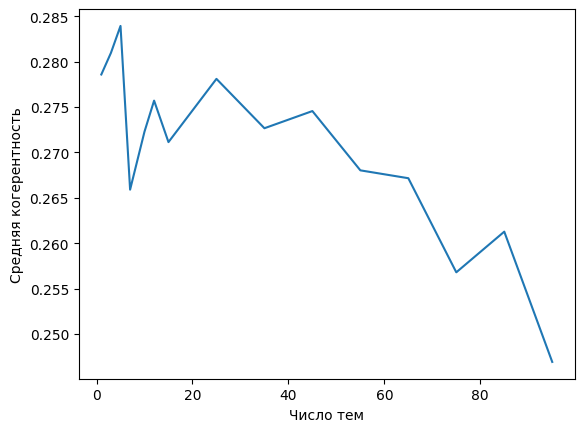

In [13]:
topics_list = [1,3,5,7,10,12] + list(range(15, 100, 10))
coherences = []

for num in tqdm(topics_list):
    lda = ldamulticore.LdaMulticore(corpus, 
                            id2word=dictionary, 
                            num_topics=num, 
                            chunksize=500, 
                            passes=2, 
                            workers=cpu_count())
    
    ch = CoherenceModel(model=lda, 
                         texts=df['text'], 
                         dictionary=dictionary, 
                         coherence='c_v').get_coherence()
    coherences.append(ch)

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Из графика видно, что оптимальное количество тем, которые могут быть распознаны моделью ~30, если число ниже 10 не удовлетворяет

In [16]:
lda_best = ldamulticore.LdaMulticore(corpus, 
                             id2word=dictionary, 
                             num_topics=30, 
                             chunksize=50, 
                             passes=2, 
                             workers=cpu_count())
vis_data_best = gensimvis.prepare(lda_best, corpus, dictionary)
pyLDAvis.save_html(vis_data_best, 'vis_best.html')
pyLDAvis.display(vis_data_best)